In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/Users/chenyilu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons or units per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers-1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)

def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons):
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model

In [4]:
import pandas as pd


In [5]:
data_training = pd.read_csv('TrainingData.txt',sep=',')
data_training = pd.DataFrame(data_training)

In [18]:
print(data_training)

              t         tf0         ts0
0    434899.530  876.974173  828.562584
1     23679.240  870.620300  874.848335
2    148408.260  686.885794  713.742917
3    329416.776  696.214946  708.247312
4    310693.656  854.880869  850.372015
..          ...         ...         ...
260  311464.608  846.538871  854.920779
261  211433.586  882.217277  871.195957
262  225999.072  838.335416  848.470132
263  511829.526  732.883182  727.348784
264  295054.344  862.968010  878.258383

[265 rows x 3 columns]


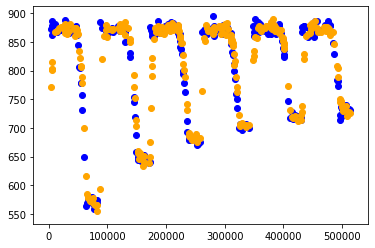

In [6]:
t = data_training["t"]
tf0 = data_training["tf0"]
ts0 = data_training["ts0"]
plt.scatter(t, tf0, c="blue" )
plt.scatter(t, ts0, c="orange")
plt.show()

In [7]:
#model definition 
my_network = NeuralNet(input_dimension=1, output_dimension=1, n_hidden_layers=2, neurons=20)


In [60]:
#weight initialization  
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 1456
# Xavier weight initialization
init_xavier(my_network, retrain)

In [2]:
#optimzer
opt_type = "ADAM"
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

NameError: name 'optim' is not defined

In [62]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):  
            
            def closure():
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. above
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. above
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                #for param in model.parameters():
                #    print(param.shape)
                #    print(param.grad)
                return loss
            
            # Item 3. above
            optimizer.step(closure=closure)
            
        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history

In [76]:
t_list = t.tolist()
t_arr = np.array(t_list) 
t_tensor = torch.from_numpy(t_arr.reshape(-1,1)).float()
tf0_list = tf0.tolist()
tf0_arr = np.array(tf0_list) 
tf0_tensor = torch.from_numpy(tf0_arr.reshape(-1,1)).float()
batch_size = 5
training_set = DataLoader(torch.utils.data.TensorDataset(t_tensor, tf0_tensor), batch_size= batch_size, shuffle = True)


In [75]:
t_tensor

tensor([[434899.5312],
        [ 23679.2402],
        [148408.2656],
        [329416.7812],
        [310693.6562],
        [172500.5156],
        [463947.9062],
        [121865.4844],
        [397122.8750],
        [312868.8438],
        [441177.2812],
        [229137.9531],
        [ 46394.7891],
        [ 21173.6465],
        [ 66990.2188],
        [146233.0781],
        [139074.2344],
        [176768.2812],
        [483717.3125],
        [176107.4688],
        [238609.6406],
        [507479.1562],
        [ 75635.8984],
        [  5203.9258],
        [ 82739.6719],
        [ 52287.0664],
        [ 34885.5781],
        [493189.0000],
        [313722.4062],
        [ 97910.9062],
        [107107.2578],
        [243345.4844],
        [399298.0625],
        [292603.8125],
        [242078.9219],
        [290621.3750],
        [282306.0938],
        [232194.2188],
        [281755.4375],
        [303314.5312],
        [ 71918.8047],
        [434679.2500],
        [472455.9062],
        [33

In [77]:
n_epochs = 2000
tf0 = fit(my_network, training_set, n_epochs, optimizer_, p=2, verbose=False )

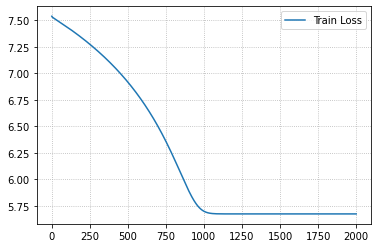

In [78]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), np.log10(tf0), label="Train Loss")
plt.legend()

In [79]:
data_testing = pd.read_csv('TestingData.txt',sep=',')
data_testing = pd.DataFrame(data_testing)

In [82]:
t_test = data_testing["t"]

t_test_list = t_test.tolist()
t_test_arr = np.array(t_test_list) 
t_test_tensor = torch.from_numpy(t_test_arr.reshape(-1,1)).float()




In [92]:
tf0_test_pred_tensor = my_network(t_test_tensor).reshape(-1,)
print(type(tf0_test_pred_tensor))
tf0_test_pred = tf0_test_pred_tensor.detach().numpy()
print(type(tf0_test_pred))



<class 'torch.Tensor'>
<class 'numpy.ndarray'>


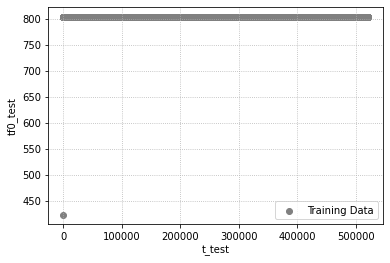

In [93]:

plt.grid(True, which="both", ls=":")
plt.scatter(t_test, tf0_test_pred, label="Training Data", marker="o", color="grey")
plt.xlabel("t_test")
plt.ylabel("tf0_test")
plt.legend()